In [29]:
import cPickle
import dill
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import operator
import pandas.io.data
from sklearn.qda import QDA
import re
from dateutil import parser
%matplotlib inline
#from backtest import Strategy, Portfolio

In [30]:
def getDataFromTrueFX(symbol, name, start, end):
    """
    Downloads Stock from Quandl.
    Computes daily Returns based on Adj Close.
    Returns pandas dataframe.
    """
    import Quandl
    df =  Quandl.get(symbol, trim_start = start, trim_end = end, authtoken="your token")

    df.columns.values[-1] = 'AdjClose'
    df.columns = df.columns + '_' + name
    df['Return_%s' %name] = df['AdjClose_%s' %name].pct_change()
    
    return df

In [31]:
df_curPair = pd.read_csv("C:\Users\saddy\Desktop\DI-Work\Data_Incubator\data\currency_data\EURUSD-2015-12.csv",\
                 header=None, names=['Bid_Ask','Date_Time','Bid', 'Ask'],\
                 parse_dates=["Date_Time"],\
                 date_parser=lambda x: pd.to_datetime(x, format="%Y%m%d %H:%M:%S.%f"),\
                 index_col="Date_Time")

df_curPair.drop([df_curPair.columns[0]], axis=1, inplace=True)

In [32]:
df_curPair_wk1 =   df_curPair.ix['2015-12-01 00:00:00':'2015-12-03 00:00:00']
df_sec_first   =   df_curPair_wk1.resample('60S', how='first')
df_sec_max     =   df_curPair_wk1.resample('60S', how='max')
df_sec_min     =   df_curPair_wk1.resample('60S', how='min')

df_sec_first.index.name='DATE'
df_sec_first = df_sec_first.reset_index()
df_sec_first.set_index(pd.DatetimeIndex(df_sec_first['DATE']), inplace = True)

df_sec_max.index.name='DATE'
df_sec_max = df_sec_max.reset_index()
df_sec_max.set_index(pd.DatetimeIndex(df_sec_max['DATE']), inplace = True)


df_sec_min.index.name='DATE'
df_sec_min = df_sec_min.reset_index()
df_sec_min.set_index(pd.DatetimeIndex(df_sec_min['DATE']), inplace = True)



In [29]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.embed import components
output_notebook()

p = figure(width=800, height=350, x_axis_type="datetime")
Bid = np.array(df_sec_first['Bid'])
Ask = np.array(df_sec_first['Ask'])
Time= np.array(df_sec_first['DATE'])

#p.circle(Time,Bid, size=4, color='pink')
p.line(Time,Bid, color='navy', alpha=0.5)
p.title = "EUR/USD Bid"
p.legend.location = "top_left"
#p.grid.grid_line_alpha = 0
p.xaxis.axis_label = 'Date Time'
p.yaxis.axis_label = 'EUR/USD'
show(p)

BokehJS successfully loaded.

In [25]:
df_sec_first.to_pickle('C:\Users\saddy\Desktop\DI-Work\Data_Incubator\data\currency_data\df_sec_first.pkl')

In [26]:
df_new = pd.read_pickle("C:\Users\saddy\Desktop\DI-Work\Data_Incubator\data\currency_data\df_sec_first.pkl")

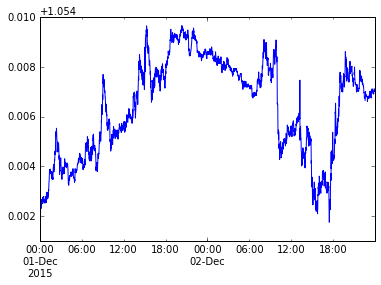

In [33]:
# Compute a window function 
import matplotlib.pyplot as plt
#minute_returns = df_sec_first.Bid.pct_change()
df_new.Bid.plot()
plt.show()

In [48]:
# Collect same "Time of Day" data across multiple days
from datetime import time
df_sec_first.at_time(time(15, 0)).head(10) # 15 is GMT equivalent of 10AM

,DATE,Bid,Ask
2015-12-01 15:00:00,2015-12-01 15:00:00,1.06139,1.0615
2015-12-02 15:00:00,2015-12-02 15:00:00,1.05743,1.0575


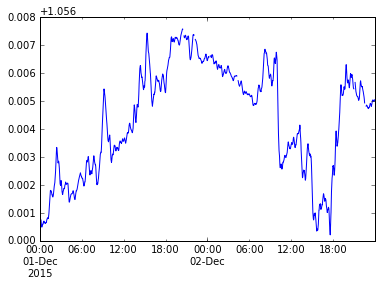

In [34]:
# Compute a window function 
import matplotlib.pyplot as plt
#minute_returns = df_sec_first.Bid.pct_change()
minute_returns = df_sec_first.Bid
std_10day = pd.rolling_mean(minute_returns, 10)
std_10day.plot()
plt.show()

In [91]:
# Dickey Fuller Test for Stationarity
from statsmodels.tsa.stattools import adfuller
import sys

#Perform Dickey-Fuller test:
print 'Results of Dickey-Fuller Test:'
try:
    dftest = adfuller(df_sec_first.Bid, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput
except :
    print "Unexpected error:", sys.exc_info()[0]
#    raise    

Results of Dickey-Fuller Test:
Unexpected error: <class 'numpy.linalg.linalg.LinAlgError'>


In [81]:
#test_stationarity(df_sec_first.Bid)
rolmean = pd.rolling_mean(timeseries, window=10)
rolstd = pd.rolling_std(timeseries, window=10)

In [4]:
df_sec_first.columns 

Index([u'DATE', u'Bid', u'Ask'], dtype='object')

In [35]:
shiftedBid = df_sec_first['Bid'].fillna(method='ffill')
shiftedBid = pd.concat([shiftedBid, df_sec_first['Bid'].shift(), df_sec_first['Bid'].shift(2), df_sec_first['Bid'].shift(3)\
                        , df_sec_first['Bid'].shift(4), df_sec_first['Bid'].shift(5)], axis=1).dropna()

shiftedBid.columns = ['bid','bid_01','bid_02','bid_03','bid_04','bid_05']

In [36]:
# Create Up-Down indicator
shiftedBid['bid_up_down'] = shiftedBid.apply(lambda row: 1 if row['bid'] >= row['bid_01'] else 0, axis=1)
shiftedBid['delta_bid_01'] = shiftedBid['bid'] - shiftedBid['bid_01']
shiftedBid['delta_bid_02'] = shiftedBid['bid'] - shiftedBid['bid_02']
shiftedBid['delta_bid_03'] = shiftedBid['bid'] - shiftedBid['bid_03']
shiftedBid['delta_bid_04'] = shiftedBid['bid'] - shiftedBid['bid_04']
shiftedBid['delta_bid_05'] = shiftedBid['bid'] - shiftedBid['bid_05']

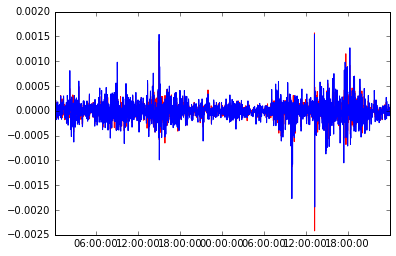

In [37]:
import matplotlib.pyplot as plt
plt.plot(shiftedBid.delta_bid_01,'r')
plt.plot(shiftedBid.delta_bid_02,'b')
plt.show()

In [28]:
plt.plot(shiftedBid.bid_01,'r')

NameError: name 'shiftedBid' is not defined

In [41]:
shiftedBid.columns

Index([u'bid', u'bid_01', u'bid_02', u'bid_03', u'bid_04', u'bid_05',
       u'bid_up_down', u'delta_bid_01', u'delta_bid_02', u'delta_bid_03',
       u'delta_bid_04', u'delta_bid_05'],
      dtype='object')

In [39]:
features = shiftedBid.columns[-5:]
response = shiftedBid.columns[-6]

In [40]:
X = shiftedBid[features]
y = shiftedBid[response]
#start_test = int(len(X)*0.6)
start_test = '2015-12-02 06:00:00'

In [41]:
X_train = X[X.index < start_test]
y_train = y[y.index < start_test]              

X_test = X[X.index >= start_test]    
y_test = y[y.index >= start_test]

In [42]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [43]:
clf.support_vectors_
clf.support_ 
clf.n_support_ 

array([811, 811])

In [81]:
clf.score(X_train, y_train)

0.54893617021276597

In [45]:
clf.score(X_test, y_test)

0.5308988764044944

In [97]:
# Add more features
shiftedBid = df_sec_first['Bid'].fillna(method='ffill')
shiftedBid = pd.concat([shiftedBid, df_sec_first['Bid'].shift(), df_sec_first['Bid'].shift(2), df_sec_first['Bid'].shift(3)\
                        , df_sec_first['Bid'].shift(4), df_sec_first['Bid'].shift(5), df_sec_first['Bid'].shift(6)\
                        , df_sec_first['Bid'].shift(7), df_sec_first['Bid'].shift(8), df_sec_first['Bid'].shift(9)\
                        , df_sec_first['Bid'].shift(10)], axis=1).dropna()

shiftedBid.columns = ['bid','bid_01','bid_02','bid_03','bid_04','bid_05','bid_06','bid_07','bid_08','bid_09','bid_10']

shiftedBid['bid_up_down'] = shiftedBid.apply(lambda row: 1 if row['bid'] >= row['bid_01'] else 0, axis=1)
shiftedBid['delta_bid_01'] = shiftedBid['bid'] - shiftedBid['bid_01']
shiftedBid['delta_bid_02'] = shiftedBid['bid'] - shiftedBid['bid_02']
shiftedBid['delta_bid_03'] = shiftedBid['bid'] - shiftedBid['bid_03']
shiftedBid['delta_bid_04'] = shiftedBid['bid'] - shiftedBid['bid_04']
shiftedBid['delta_bid_05'] = shiftedBid['bid'] - shiftedBid['bid_05']
shiftedBid['delta_bid_06'] = shiftedBid['bid'] - shiftedBid['bid_06']
shiftedBid['delta_bid_07'] = shiftedBid['bid'] - shiftedBid['bid_07']
shiftedBid['delta_bid_08'] = shiftedBid['bid'] - shiftedBid['bid_08']
shiftedBid['delta_bid_09'] = shiftedBid['bid'] - shiftedBid['bid_09']
shiftedBid['delta_bid_10'] = shiftedBid['bid'] - shiftedBid['bid_10']

In [98]:
features = shiftedBid.columns[-10:]
response = shiftedBid.columns[-11]

X = shiftedBid[features]
y = shiftedBid[response]
start_test = '2015-12-02 00:00:00'

X_train = X[X.index < start_test]
y_train = y[y.index < start_test]              

X_test = X[X.index >= start_test]    
y_test = y[y.index >= start_test]

In [102]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression  as LR
clf = svm.SVC()
clf.fit(X_train, y_train).score(X_train, y_train)  


0.54893617021276597

In [104]:
lr = LR()
lr.fit(X_train, y_train).score(X_train, y_train)  

0.54893617021276597

In [49]:
clf.fit(X_train, y_train).score(X_test, y_test)  

0.53290414878397707

In [50]:
1.0*sum(y_train)/len(y_train)

0.54893617021276597

In [51]:
1.0*sum(y_test)/len(y_test)

0.53290414878397707

In [95]:
y_pred = clf.fit(X_train, y_train).predict(X_train[0:10])  

In [96]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [90]:
y_test[0:10]

2015-12-02 00:00:00    1
2015-12-02 00:01:00    0
2015-12-02 00:02:00    1
2015-12-02 00:03:00    0
2015-12-02 00:04:00    1
2015-12-02 00:05:00    1
2015-12-02 00:06:00    1
2015-12-02 00:07:00    1
2015-12-02 00:08:00    0
2015-12-02 00:09:00    1
Name: bid_up_down, dtype: int64

In [57]:
sum(y_pred)

1398

In [76]:
X_test[0:3]

,delta_bid_01,delta_bid_02,delta_bid_03,delta_bid_04,delta_bid_05,delta_bid_06,delta_bid_07,delta_bid_08,delta_bid_09,delta_bid_10
2015-12-02 00:00:00,0.00011,0.00010,0.00011,0.00012,0.00028,0.00024,0.00022,0.00025,0.00017,0.00011
2015-12-02 00:01:00,-0.00011,0.00000,-0.00001,0.00000,0.00001,0.00017,0.00013,0.00011,0.00014,0.00006
2015-12-02 00:02:00,0.00010,-0.00001,0.00010,0.00009,0.00010,0.00011,0.00027,0.00023,0.00021,0.00024


In [85]:
sum(y_test)

745

In [86]:
len(y_test)

1398